In [62]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn import datasets
from jupyterthemes import jtplot
from PIL import Image
jtplot.style()
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

#### 用いるデータセット

array([[ 0.74346118,  0.46465633],
       [ 1.65755662, -0.63203157],
       [-0.15878875,  0.25584465],
       [-1.088752  , -0.39694315],
       [ 1.768052  , -0.25443213],
       [ 1.95416454, -0.12850579],
       [ 0.93694537,  0.36597075],
       [ 0.88446589, -0.47595401],
       [ 0.80950246,  0.3505231 ],
       [ 1.2278091 , -0.64785108]])

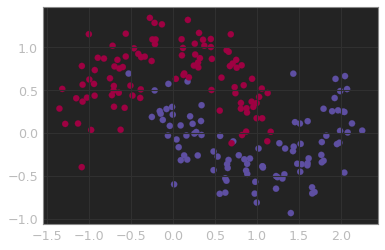

In [63]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
X[0:10,:]
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

線形分離不可能なデータセット

非線形的に分離するため、今まで素性2と固定定数項x0,x1,x2でやっていたところに$x_3 = x_1^2$を加える

#### 非線形に分離する識別関数の規定と各教師データでの値算出

In [64]:
th = [0.1,0.2,0.4,2.0]
#識別関数の定義（データセットの変形,theta初期化）
def makefx(data):
    f_x = np.empty(shape=(4,data.shape[0]))
    #x0=0
    ones = np.ones(shape=(1,data.shape[0]))
    f_x[0,:] = ones
    #x1,x2に教師データの2要素が入る
    f_x[1:3,:] = data.T[0:2]
    #x3=x1^2
    f_x[3,:] = data.T[0,:]**2
    return f_x.T
sample = makefx(X)
sample[0:10,:]

array([[ 1.        ,  0.74346118,  0.46465633,  0.55273452],
       [ 1.        ,  1.65755662, -0.63203157,  2.74749394],
       [ 1.        , -0.15878875,  0.25584465,  0.02521387],
       [ 1.        , -1.088752  , -0.39694315,  1.18538091],
       [ 1.        ,  1.768052  , -0.25443213,  3.12600786],
       [ 1.        ,  1.95416454, -0.12850579,  3.81875906],
       [ 1.        ,  0.93694537,  0.36597075,  0.87786663],
       [ 1.        ,  0.88446589, -0.47595401,  0.78227992],
       [ 1.        ,  0.80950246,  0.3505231 ,  0.65529423],
       [ 1.        ,  1.2278091 , -0.64785108,  1.50751518]])

各教師データに対して

$\boldsymbol{x}^{(prac)} = [ x_0=0,x_1,x_2,x_3=x_1^2 ]^T$

が用意できたので、識別関数を形作るには

$\boldsymbol{θ^Tx}^{(prac)}$

とすればよい。また、これをシグモイド関数へ適用して分類確率とする。

### 初期状態でのシグモイド関数の可視化

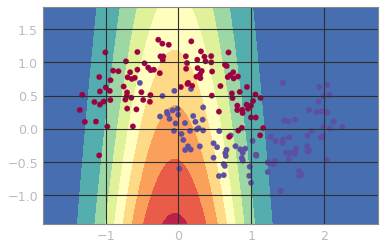

In [65]:
#通常の1引数シグモイド関数
def sigmoid(x):
    return 1.0/(1.0+np.exp(-1.0*x))

#今回の識別関数用にσ(θx)を計算する関数
def sigmoidP(thArr,xArr):
    return sigmoid(np.dot(thArr,xArr))

def showSigmoidP(randSample, thArr, axis1=1, axis2=2):
    for s in randSample:
        ret = plt.scatter(s[axis1],s[axis2],c=cm.hot(sigmoidP(thArr,s)))


#ランダムサンプルで現在の識別関数の様子を見る
#randsample = makefx(np.random.choice(np.arange(-1.5,2.5,0.01), size=X.shape))
#showSigmoidP(randsample, th)
#plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

plot_decision_boundary(lambda x:sigmoidP(makefx(x),th))

初期状態のため教師データを分離するようにはなっていないが、非線形的に分離可能な形状であることがわかる 

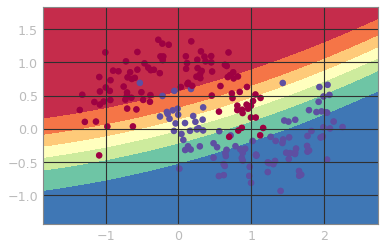

In [66]:
def train(sample, labels, thetas, trainRoop, eta=50, logFlg=True):    
    for n in range(trainRoop):
        G = np.zeros(sample.shape[1])
        for j in range(sample.shape[1]):    
            for i,samp in enumerate(sample):
                G[j] = G[j] + (sigmoidP(thetas, samp)-labels[i])*samp[j]
        if logFlg:
            print("G=",G)
            print("thOld=",thetas)
        thetas = thetas - eta * np.array(G)
        if logFlg:
            print("thNew=",thetas)
    return thetas

th = train(sample, y, th, 50, eta=0.01, logFlg=False)

#showSigmoidP(randsample, th)

plot_decision_boundary(lambda x:sigmoidP(makefx(x),th))
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

非線形的な分離ができると言っても二次関数的な形状のため、このmake_moon形状はうまく分離できていない

### 3次関数的な非線形分離
重み$\boldsymbol{θ}$と識別関数の素性を変えれば様々な非線形分離が可能

以下では$\boldsymbol{x}^{(prac)}=[x_0=0, x_1, x_2, x_3=x_1^2, x_4=x_1^3]$とする。

今回利用する素性
[[  1.00000000e+00   7.43461176e-01   4.64656328e-01   5.52734521e-01
    4.10936657e-01]
 [  1.00000000e+00   1.65755662e+00  -6.32031569e-01   2.74749394e+00
    4.55412676e+00]
 [  1.00000000e+00  -1.58788748e-01   2.55844647e-01   2.52138665e-02
   -4.00367829e-03]
 [  1.00000000e+00  -1.08875200e+00  -3.96943154e-01   1.18538091e+00
   -1.29058584e+00]
 [  1.00000000e+00   1.76805200e+00  -2.54432127e-01   3.12600786e+00
    5.52694444e+00]
 [  1.00000000e+00   1.95416454e+00  -1.28505794e-01   3.81875906e+00
    7.46248356e+00]
 [  1.00000000e+00   9.36945369e-01   3.65970753e-01   8.77866625e-01
    8.22513069e-01]
 [  1.00000000e+00   8.84465895e-01  -4.75954007e-01   7.82279919e-01
    6.91899909e-01]
 [  1.00000000e+00   8.09502459e-01   3.50523097e-01   6.55294231e-01
    5.30462291e-01]
 [  1.00000000e+00   1.22780910e+00  -6.47851081e-01   1.50751518e+00
    1.85094086e+00]]
識別関数の値と教師データプロット


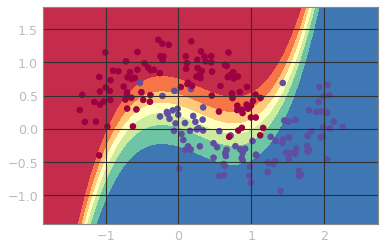

In [67]:
#識別関数の定義（データセットの変形,theta初期化）
th_tri = [0.1,0.2,0.4,2.0,5.0]
def makefx_tri(data):
    f_x = np.empty(shape=(5,data.shape[0]))
    #x0=0
    ones = np.ones(shape=(1,data.shape[0]))
    f_x[0,:] = ones
    #x1,x2に教師データの2要素が入る
    f_x[1:3,:] = data.T[0:2]
    #x3=x1^2
    f_x[3,:] = data.T[0,:]**2
    f_x[4,:] = data.T[0,:]**3
    return f_x.T

sample_tri = makefx_tri(X)
print("今回利用する素性")
print(sample_tri[0:10,:])

#学習
th_tri = train(sample_tri, y, th_tri, 50, eta=0.01, logFlg=False)

print("識別関数の値と教師データプロット")
#教師データに対する識別関数の形を見る
randsample_tri = makefx_tri(np.random.choice(np.arange(-1.5,2.5,0.01), size=(800,X.shape[1])))
plot_decision_boundary(lambda x:sigmoidP(makefx_tri(x),th_tri))

#showSigmoidP(randsample_tri, th_tri)

ret = plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

うまく月型を分離できている